In [1]:
"""方差选择"""
from sklearn.feature_selection import VarianceThreshold
import numpy as np

# 示例数据（特征0方差为0，特征1方差为0.25）
X = np.array([[0, 1], 
              [0, 2], 
              [0, 3], 
              [0, 4]])

# 剔除方差<0.1的特征
selector = VarianceThreshold(threshold=0.1)
X_filtered = selector.fit_transform(X)
print("方差选择结果:\n", X_filtered)
# 输出：仅保留特征1（第二列）

方差选择结果:
 [[1]
 [2]
 [3]
 [4]]


In [2]:
"""卡方检验"""
from sklearn.feature_selection import SelectKBest, chi2

# 示例数据（特征0与目标无关，特征1强相关）
X = np.array([[1, 1], 
              [0, 1], 
              [0, 0], 
              [1, 0]])
y = np.array([1, 1, 0, 0])  # 二分类目标

# 选择Top 1特征
selector = SelectKBest(chi2, k=1)
X_filtered = selector.fit_transform(X, y)
print("卡方检验选择结果:\n", X_filtered)
# 输出：仅保留特征1（第二列）

卡方检验选择结果:
 [[1]
 [1]
 [0]
 [0]]


In [3]:
"""互信息"""
from sklearn.feature_selection import mutual_info_classif

# 示例数据（4个样本，2个特征）
X_classif = np.array([
    [0.1, 0.9],  # 特征1与目标正相关，特征2与目标负相关
    [0.2, 0.8],
    [0.3, 0.7],
    [0.4, 0.6]
])
y_classif = np.array([0, 1, 1, 0])  # 二分类目标

# 计算互信息（显式设置n_neighbors=2避免报错）
mi_classif = mutual_info_classif(X_classif, y_classif, n_neighbors=2, random_state=42)
print("分类任务互信息得分:", mi_classif)
# 输出示例: [0.        0.33333333] 
# 解释：特征0与目标无关（得分为0），特征1与目标相关（得分>0）

from sklearn.feature_selection import mutual_info_regression

# 示例数据（特征0与目标线性相关，特征1为噪声）
X_reg = np.array([
    [1.0, 0.1],
    [2.0, 0.2],
    [3.0, 0.3],
    [4.0, 0.4]
])
y_reg = np.array([1.1, 2.0, 3.1, 4.0])  # 连续目标

# 计算互信息
mi_reg = mutual_info_regression(X_reg, y_reg, n_neighbors=2, random_state=42)
print("回归任务互信息得分:", mi_reg)
# 输出示例: [0.21654046 0.        ]
# 解释：特征0与目标强相关，特征1无关

分类任务互信息得分: [0.08333333 0.        ]
回归任务互信息得分: [0.33333333 0.33333333]


In [4]:
"""皮尔逊相关系数"""
import pandas as pd

# 示例数据
df = pd.DataFrame({'Feature1': [1, 2, 3, 4],
                   'Feature2': [4, 3, 2, 1],
                   'Target': [1, 2, 3, 4]})

# 计算所有特征与目标的相关系数
corr = df.corr()['Target'].abs().sort_values(ascending=False)
print("皮尔逊相关系数:\n", corr)
# 输出：Feature1与Target完全正相关（r=1）

皮尔逊相关系数:
 Feature1    1.0
Feature2    1.0
Target      1.0
Name: Target, dtype: float64


In [5]:
"""费舍尔得分"""
from sklearn.datasets import make_classification

# 生成示例数据
X, y = make_classification(n_samples=100, n_features=5, n_classes=2, random_state=42)

def fisher_score(X, y):
    classes = np.unique(y)
    overall_mean = np.mean(X, axis=0)
    score = np.zeros(X.shape[1])
    
    for c in classes:
        X_c = X[y == c]
        n_c = len(X_c)
        mean_c = np.mean(X_c, axis=0)
        var_c = np.var(X_c, axis=0)
        
        score += n_c * (mean_c - overall_mean) ** 2 / (var_c + 1e-6)  # 避免除零
    
    return score

f_scores = fisher_score(X, y)
print("费舍尔得分:", f_scores)

费舍尔得分: [  4.30247557 142.92164289   1.20428347 300.55519485   0.46944001]


In [6]:
"""信息增益"""
from sklearn.feature_selection import mutual_info_classif

# 示例数据（离散特征需编码）
X = np.array([[0, 1],  # 特征0取值为0/1，特征1取值为1/2/3
              [1, 2],
              [0, 3],
              [1, 1]])
y = np.array([0, 1, 0, 1])  # 二分类目标

# 计算信息增益（互信息分类即信息增益）
ig = mutual_info_classif(X, y, discrete_features=True)
print("信息增益得分:", ig)

信息增益得分: [0.69314718 0.34657359]


In [7]:
"""前向搜索特征消除"""
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector

# 加载示例数据（乳腺癌数据集）
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# 初始化模型（这里用随机森林，分类任务）
model = RandomForestClassifier(n_estimators=10, random_state=42)

# 前向搜索：选择5个最优特征
sfs_forward = SequentialFeatureSelector(
    estimator=model,
    k_features=5,           # 选择5个特征
    forward=True,           # True=前向搜索，False=后向搜索
    scoring='accuracy',     # 评估指标（分类用accuracy，回归用neg_mean_squared_error）
    cv=5                   # 5折交叉验证
)
sfs_forward.fit(X, y)

# 输出结果
print("前向搜索选中的特征索引:", sfs_forward.k_feature_idx_)
print("特征名称:", [data.feature_names[i] for i in sfs_forward.k_feature_idx_])
print("交叉验证准确率:", sfs_forward.k_score_)

前向搜索选中的特征索引: (3, 7, 21, 22, 24)
特征名称: [np.str_('mean area'), np.str_('mean concave points'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst smoothness')]
交叉验证准确率: 0.9666200900481293


In [8]:
"""后向搜索特征消除"""
from mlxtend.feature_selection import SequentialFeatureSelector

# 后向搜索：选择5个最优特征
sfs_backward = SequentialFeatureSelector(
    estimator=model,
    k_features=5,
    forward=False,  # False表示后向搜索
    scoring='accuracy',
    cv=5
)
sfs_backward.fit(X, y)

# 输出结果
print("后向搜索选中的特征索引:", sfs_backward.k_feature_idx_)
print("特征名称:", [data.feature_names[i] for i in sfs_backward.k_feature_idx_])
print("交叉验证准确率:", sfs_backward.k_score_)

后向搜索选中的特征索引: (7, 15, 21, 23, 27)
特征名称: [np.str_('mean concave points'), np.str_('compactness error'), np.str_('worst texture'), np.str_('worst area'), np.str_('worst concave points')]
交叉验证准确率: 0.9595714951094549


In [9]:
"""递归特征消除"""
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

# 加载数据
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# 数据标准化（重要！）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 初始化模型（增加max_iter，使用liblinear求解器）
model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# RFE选择5个特征
rfe = RFE(
    estimator=model,
    n_features_to_select=5,
    step=1
)
rfe.fit(X_scaled, y)

# 输出结果
print("RFE选中的特征:", X.columns[rfe.support_])
print("特征排名（1表示选中）:", rfe.ranking_)
print("模型权重（系数）:", rfe.estimator_.coef_)

RFE选中的特征: Index(['radius error', 'worst radius', 'worst texture', 'worst area',
       'worst concave points'],
      dtype='object')
特征排名（1表示选中）: [12 14 15  8 23 10 13  3 25 20  1 22  9  4 18  6 24 21 19 16  1  1  2  1
  7 26  5  1 11 17]
模型权重（系数）: [[-1.55149116 -1.96147028 -1.39076982 -1.90805953 -2.72579625]]


最佳alpha值（通过交叉验证）: 0.09362216016463504

被选择的特征数量: 10
被选择的特征索引: [ 6 14 17 23 27 28 58 76 80 96]


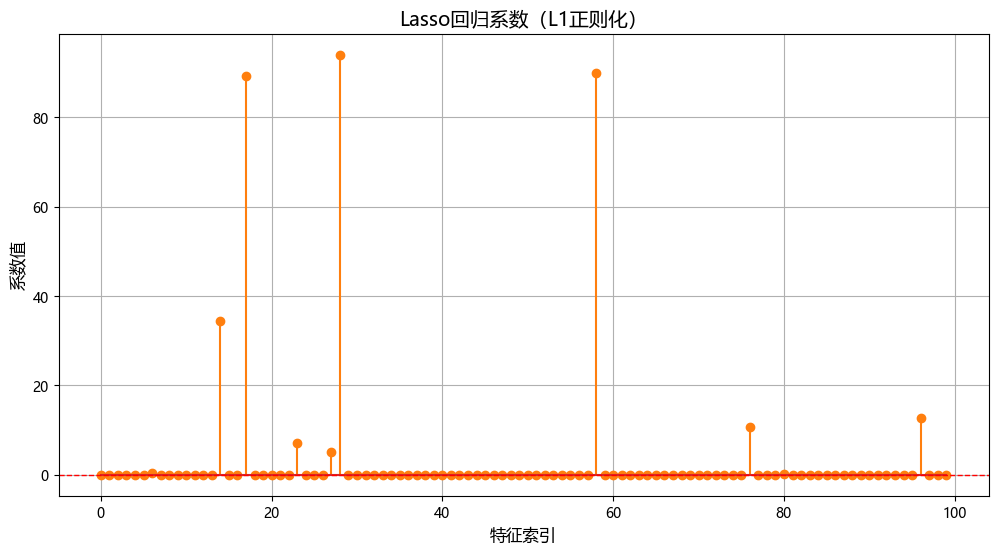


模型性能：
训练集R²: 0.9999880837571014
测试集R²: 0.9999886509168658


In [10]:
"""嵌入式选择与L1正则化"""
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'Microsoft YaHei'

# 1. 生成模拟数据（100个特征，其中只有10个是真实有用的）
X, y = make_regression(n_samples=500, n_features=100, n_informative=10, 
                       noise=0.5, random_state=42)

# 2. 数据标准化（L1正则化对特征尺度敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 4. 使用Lasso进行嵌入式特征选择
# 方法1：手动指定alpha（正则化强度）
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train, y_train)

# 方法2：使用交叉验证自动选择最佳alpha（推荐）
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

# 5. 结果分析
print("最佳alpha值（通过交叉验证）:", lasso_cv.alpha_)

# 获取非零系数的特征（被选择的特征）
nonzero_features = np.where(lasso_cv.coef_ != 0)[0]
print("\n被选择的特征数量:", len(nonzero_features))
print("被选择的特征索引:", nonzero_features)

# 6. 可视化系数
plt.figure(figsize=(12, 6))
plt.stem(range(len(lasso_cv.coef_)), lasso_cv.coef_, markerfmt='C1o', linefmt='C1-')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("特征索引", fontsize=12)
plt.ylabel("系数值", fontsize=12)
plt.title("Lasso回归系数（L1正则化）", fontsize=14)
plt.grid(True)
plt.show()

# 7. 模型评估
print("\n模型性能：")
print("训练集R²:", lasso_cv.score(X_train, y_train))
print("测试集R²:", lasso_cv.score(X_test, y_test))

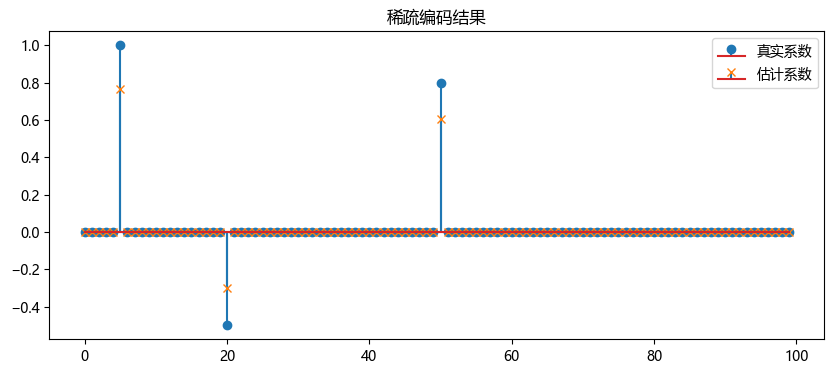

In [11]:
"""稀疏编码"""
from sklearn.linear_model import Lasso

# 生成字典（DCT基）
n_atoms = 100
signal_length = 64
D = np.zeros((signal_length, n_atoms))
for k in range(n_atoms):
    D[:, k] = np.cos(np.linspace(0, np.pi*k, signal_length))

# 生成稀疏信号
x_true = np.zeros(n_atoms)
x_true[[5, 20, 50]] = [1.0, -0.5, 0.8]  # 稀疏系数
y = D @ x_true + 0.1 * np.random.randn(signal_length)  # 添加噪声

# 稀疏编码（L1正则化）
lasso = Lasso(alpha=0.1)
lasso.fit(D, y)
x_sparse = lasso.coef_

# 可视化
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.stem(x_true, label="真实系数", markerfmt='C0o')
plt.stem(x_sparse, label="估计系数", markerfmt='C1x')
plt.legend()
plt.title("稀疏编码结果")
plt.show()

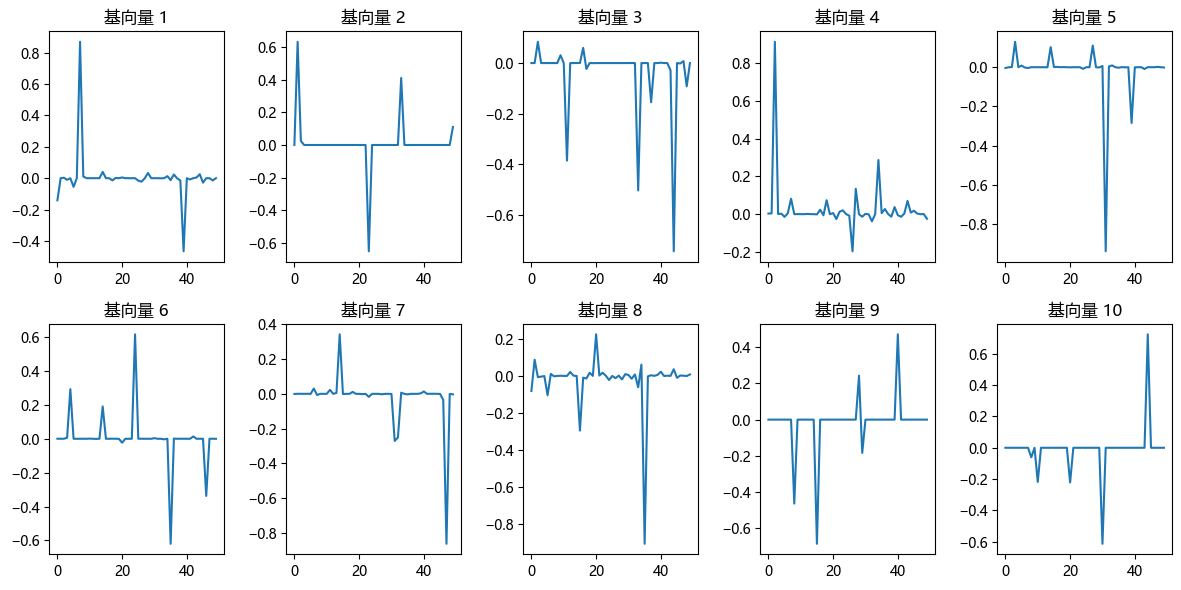

In [12]:
"""字典学习"""
from sklearn.decomposition import DictionaryLearning
from sklearn.datasets import make_sparse_coded_signal

# 生成合成数据（100个信号，每个信号在50原子字典下稀疏）
n_samples = 100
n_atoms = 50
n_features = 64
D_true, X_true, Y = make_sparse_coded_signal(
    n_samples=n_samples,
    n_components=n_atoms,
    n_features=n_features,
    n_nonzero_coefs=5,
    random_state=42
)

# 字典学习
dl = DictionaryLearning(n_components=n_atoms, alpha=0.5, max_iter=100)
D_learned = dl.fit(Y).components_

# 可视化字典原子
plt.figure(figsize=(12, 6))
for i in range(10):  # 显示前10个原子
    plt.subplot(2, 5, i+1)
    plt.plot(D_learned[i])
    plt.title(f"基向量 {i+1}")
plt.tight_layout()
plt.show()

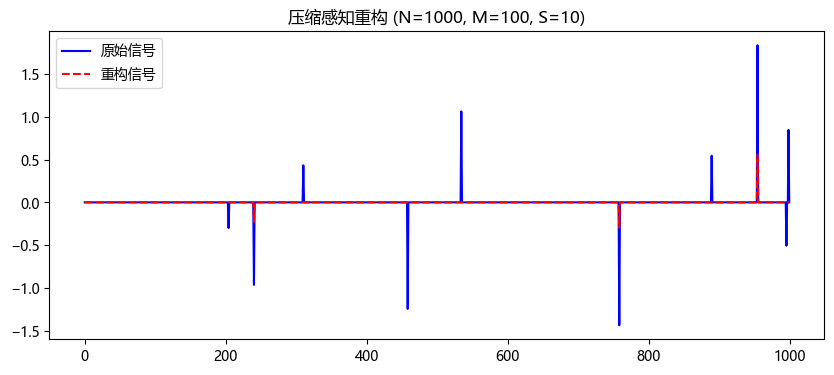

In [18]:
"""信号压缩与重构"""
from sklearn.linear_model import Lasso

# 生成稀疏信号（N=1000，仅有S=10个非零值）
N, S = 1000, 10
x = np.zeros(N)
x[np.random.choice(N, S, replace=False)] = np.random.randn(S)

# 随机测量矩阵（M=100）
M = 100
A = np.random.randn(M, N) / np.sqrt(M)
y = A @ x  # 压缩观测

# L1最小化重构（等效基追踪）
lasso = Lasso(alpha=0.01)
lasso.fit(A, y)
x_recon = lasso.coef_

# 可视化
plt.figure(figsize=(10, 4))
plt.plot(x, 'b-', label='原始信号')
plt.plot(x_recon, 'r--', label='重构信号')
plt.legend()
plt.title(f"压缩感知重构 (N={N}, M={M}, S={S})")
plt.show()

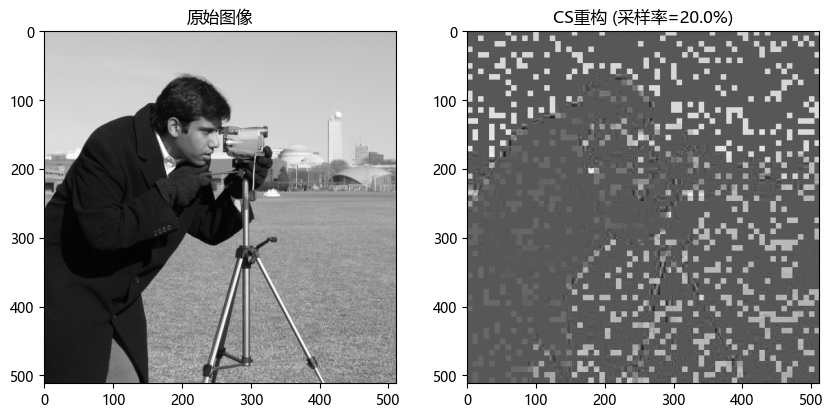

In [17]:
"""图像压缩感知"""
from scipy.fftpack import dctn, idctn
from skimage.data import camera

# 读取图像并分块
image = camera().astype(float) / 255
block_size = 8

# 对每个8x8块进行DCT变换（稀疏表示）
dct_coeffs = np.zeros_like(image)
for i in range(0, image.shape[0], block_size):
    for j in range(0, image.shape[1], block_size):
        dct_coeffs[i:i+block_size, j:j+block_size] = dctn(
            image[i:i+block_size, j:j+block_size]
        )

# 随机采样部分系数（模拟压缩感知）
sampling_ratio = 0.2  # 仅保留20%的系数
mask = np.random.rand(*image.shape) < sampling_ratio
sampled_coeffs = dct_coeffs * mask

# 重构图像（IDCT + 填充未采样系数为0）
recon_image = np.zeros_like(image)
for i in range(0, image.shape[0], block_size):
    for j in range(0, image.shape[1], block_size):
        recon_image[i:i+block_size, j:j+block_size] = idctn(
            sampled_coeffs[i:i+block_size, j:j+block_size]
        )

# 可视化
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title("原始图像")
plt.subplot(122)
plt.imshow(recon_image, cmap='gray')
plt.title(f"CS重构 (采样率={sampling_ratio*100}%)")
plt.show()